<a href="https://colab.research.google.com/github/GurjeetSinghSangra/MachineLearningAssignment/blob/main/emnist_DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
##################################################
# Imports
##################################################

import numpy as np
import numpy.matlib
import math
import scipy.io
from sklearn import svm, datasets
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn #torch made by layers, in nn we have linear layer which implements standard forward fully connected layer
import torch.nn.functional as F 
import torchvision #used for data loading
import torch.optim as optim #optimizer for the gradient
from tqdm.notebook import tqdm
import time


# Setting the device
if torch.cuda.is_available(): 
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    

GPU enabled!


In [30]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
#images = np.apply_along_axis(rotate, 1, x_train)
#plt.imshow(images[1,], cmap=plt.get_cmap('gray')) 

In [31]:
class DBN(nn.Module):

  def __init__(self, layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1, \
                               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    super(DBN, self).__init__()
    self.DN = {}
    self.DN['layersize'] = layers_nn
    self.DN['nlayers'] = len(layers_nn)
    self.DN['batchsize'] = batchsize
    self.DN['maxepochs'] = maxepochs
    self.epsilonw_GPU = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.initialmomentum = init_momentum
    self.finalmomentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
    self.DN['errors'] = {}
  
  def train_dbn(self, batchdata, device):

    batchdata = batchdata.to(device)
    nlayers = self.DN['nlayers']
    for layer in range(0, nlayers):
        print ('Training layer ', layer+1, '...')
        if layer == 0:
            data_GPU = batchdata
        else:
            data_GPU = batchposhidprobs
        
        data_GPU.to(device)
        numhid = self.DN['layersize'][layer]
        numcases, numdims, numbatches = data_GPU.shape
        vishid_GPU       = 0.1 * torch.randn(numdims, numhid).to(device) #normal dist weights with standard deviation 0.01
        #print(vishid_GPU.shape)
        hidbiases_GPU    = torch.zeros(numhid).to(device)
        visbiases_GPU    = torch.zeros(numdims).to(device)
        vishidinc_GPU    = torch.zeros((numdims, numhid)).to(device)
        hidbiasinc_GPU   = torch.zeros(numhid).to(device)
        visbiasinc_GPU   = torch.zeros(numdims).to(device)
        batchposhidprobs = torch.zeros((numcases, numhid, numbatches)).to(device)
        self.DN['errors'][layer] = []


        sigmoid = nn.Sigmoid()
        for epoch in range(self.DN['maxepochs']):
            errsum = 0
            for mb in range(numbatches):
                data_mb = data_GPU[:, :, mb]
                #%%%%%%%% START POSITIVE PHASE %%%%%%%%%
                #1./(1 + exp(-poshidstates * vishid' - repmat(visbiases, numcases, 1))); 
                poshidprobs_GPU = sigmoid((torch.mm(data_mb, vishid_GPU) + hidbiases_GPU)).to(device)
                posprods_GPU    = torch.mm(data_mb.T, poshidprobs_GPU)
                poshidact_GPU   = poshidprobs_GPU.sum(0)
                #posvisact_GPU   = data_GPU[:, :, mb].sum(0)
                posvisact_GPU   = data_mb.sum(0)
                #%%%%%%%% END OF POSITIVE PHASE %%%%%%%%%
                poshidstates_GPU = poshidprobs_GPU > (torch.rand(numcases, numhid).to(device))
                poshidstates_GPU = torch.gt(poshidstates_GPU, 0).float()

                #%%%%%%%% START NEGATIVE PHASE  %%%%%%%%%
                negdata_GPU     = sigmoid((torch.mm(poshidstates_GPU, vishid_GPU.T) + visbiases_GPU))
                neghidprobs_GPU = sigmoid((torch.mm(negdata_GPU, vishid_GPU) + hidbiases_GPU))
                negprods_GPU    = torch.mm(negdata_GPU.T, neghidprobs_GPU)
                neghidact_GPU   = neghidprobs_GPU.sum(0)
                negvisact_GPU   = negdata_GPU.sum(0)
                #%%%%%%%% END OF NEGATIVE PHASE %%%%%%%%%
                
                err = torch.sqrt(torch.sum(torch.sum((data_mb - negdata_GPU)**2, dim=0)))
                if self.DN['maxepochs']  > 5:
                  self.momentum = self.finalmomentum
                else:
                  self.momentum = self.initialmomentum

                #%%%%%%%% UPDATE WEIGHTS AND BIASES %%%%%%%%%
                vishidinc_GPU  = vishidinc_GPU  * self.momentum + self.epsilonw_GPU * ((posprods_GPU - negprods_GPU) / numcases - self.weightcost * vishid_GPU)
                visbiasinc_GPU = visbiasinc_GPU * self.momentum + (posvisact_GPU - negvisact_GPU) * (self.epsilonvb / numcases)
                hidbiasinc_GPU = hidbiasinc_GPU * self.momentum + (poshidact_GPU - neghidact_GPU) * (self.epsilonhb / numcases)
                vishid_GPU     = vishid_GPU + vishidinc_GPU
                visbiases_GPU  = visbiases_GPU + visbiasinc_GPU
                hidbiases_GPU  = hidbiases_GPU + hidbiasinc_GPU
                #%%%%%%%% END OF UPDATES %%%%%%%%%
                # END RBM
                
                errsum = err + errsum

                if epoch == self.DN['maxepochs']-1:
                    batchposhidprobs[:, :, mb] = poshidprobs_GPU

                #TODO: Sparsity
                if self.sparsity and (layer == nlayers-1):
                  #poshidact_GPU = poshidprobs_GPU.sum(0)
                  Q = poshidact_GPU / self.DN['batchsize']
                  if (torch.mean(Q) > self.spars_factor):
                    hidbiases_GPU = hidbiases_GPU - self.epsilonhb * (Q - self.spars_factor)
              
            #END Batches
            self.DN['errors'][layer].append((epoch, errsum.cpu().clone().numpy()))
          #END Epoches

        # save learned weights
        self.DN['vis_bias' + str(layer)] = visbiases_GPU.cpu().clone().numpy()
        self.DN['hid_bias' + str(layer)] = hidbiases_GPU.cpu().clone().numpy()
        self.DN['vishid'   + str(layer)] = vishid_GPU.cpu().clone().numpy()
        #print(self.DN['vishid'   + str(layer)].shape)

  def load_data(fname, NUMB_CLASSES, batchsize):
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)

    iterations = int(len(x_train)/batchsize)
    batchdata = np.zeros(shape=(batchsize,784,iterations), dtype='float32')
    for i in range(iterations) :
        for j in range(batchsize):
            batchdata[j, :,i] = x_train[i+j, :]

    length_train = int(len(x_train))
    tr_labels = np.zeros(shape=(length_train, NUMB_CLASSES))
    for i in range(length_train):
        tr_labels[i, y_train[i]] = 1

    length_test = int(len(y_test))
    te_labels = np.zeros(shape=(length_test, NUMB_CLASSES))
    for i in range(length_test):
        te_labels[i, y_test[i]] = 1

    x_trainGPU = torch.from_numpy(batchdata)
    return (x_train, tr_labels, x_test, te_labels, x_trainGPU)

    def to_string(self):
      return "DBN: {0}, {1}, {2}".format(str(self.DN['layersize']), self.DN[batchsize], self.DN[maxepochs])

  

In [44]:
##################################################
# SVM Class
##################################################
class SVM(object):
    def __init__(self, theta_dim=3, seed=1234):
        np.random.seed(seed)
        self.theta = np.random.normal(loc=0.01, size=[theta_dim, 1]) # shape [theta_dim, 1]
        self.theta[-1] = 0 # Zero initialization for the bias

    def forward(self, x):
        '''
        input x: ndarray of shape [N, theta_dim]
        output h: ndarray of shape [N, 1]
        '''
        h = np.dot(x, self.theta)
        return h

    def loss(self, h, y, C):
        '''
        input h: ndarray of shape [N, 1]
        input y: ndarray of shape [N, 1]
        output j: scalar
        '''
        j = C * ((y * np.maximum(0, 1 - h)) + ((1-y) *np.maximum(0, 1+ h))).sum() + 1/2 * np.sum(self.theta**2)
        return j

    def fit(self, x, y, x_val, y_val, C=1, lr=1e-3, iterations=100, print_every=10, batch_size=32, seed=1234):
        '''
        input x: ndarray of shape [N, theta_dim]
        input y: ndarray of shape [N, 1]
        '''
        idx_samples = np.arange(len(x))
        loss = {'train': [], 'validation': []}
        for it in range(iterations):

            # Batches
            np.random.seed(seed)
            np.random.shuffle(idx_samples)
            num_batches = int(np.ceil(len(x) / batch_size))
            loss_epoch = []
            for idx_b in range(num_batches):
                idx_batch = idx_samples[idx_b * batch_size : (idx_b + 1) * batch_size]
                x_batch, y_batch = x[idx_batch], y[idx_batch]

                # Forward and loss
                h = self.forward(x_batch) # shape [batch_size,]
                loss_epoch += [self.loss(h, y_batch, C=C)]
            
                # Compute the gradient
                grad = 1.0 * (y_batch == 0) * (h >= -1) - 1.0 * (y_batch == 1) * (h <= 1)
                print(grad.shape)
                print(x_batch.shape[-1])
                print(np.tile(grad, (1, x_batch.shape[-1])).shape)
                grad = C * (np.tile(grad, (1, x_batch.shape[-1])) * x_batch).sum(axis=0, keepdims=True).T
                grad = grad + self.theta

                # Update the gradient
                self.theta = self.theta - lr * grad

            loss['train'] += [np.mean(loss_epoch)]

            # Validation step
            h_val = self.forward(x_val)
            loss['validation'] += [self.loss(h_val, y_val, C=C)]

            # Print log
            if print_every is not None:
                if (it % print_every == 0) or (it == iterations - 1):
                    print(f'Iter: {it}\n\ttrain loss {loss["train"][-1]:.3f}, validation loss {loss["validation"][-1]:.3f}')
        return loss

    def predict(self, x):
        '''
        input x: ndarray of shape [N, theta_dim]
        output y_: ndarray of shape [N, 1]
        '''
        y_ = None
        h = self.forward(x)
        y_ = 1 * (h>=0) 
        
        return y_

    def evaluate(self, x, y, metric_func):
        '''
        input x: ndarray of shape [N, theta_dim]
        input y: ndarray of shape [N, 1]
        input metric_func: function for evaluation
        '''
        y_ = self.predict(x)
        return metric_func(y_, y)

In [33]:
from scipy.linalg import lstsq
def perceptron_CPU(tr_patterns, tr_labels, te_patterns, te_labels):

  te_accuracy = 0;
  tr_accuracy = 0;

  # add biases
  tr_patterns_CPU = np.hstack((tr_patterns, np.ones((len(tr_patterns), 1))))

  print(tr_patterns_CPU.shape)
  print(tr_labels.shape)
  # train with pseudo-inverse
  weights, res, rnk, s= lstsq(tr_patterns_CPU, tr_labels)
  #weights = (tr_labels'*pinv(tr_patterns'))';

  # training accuracy
  print(weights.shape)
  pred = np.dot(tr_patterns_CPU, weights)
  print(pred.shape)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(tr_labels)[1]
  acc = max_act_idx == r

  tr_accuracy = np.mean(acc)

  # test accuracy
  te_patterns_CPU = np.hstack((te_patterns, np.ones((len(te_patterns), 1))))
  pred = np.dot(te_patterns_CPU, weights)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(te_labels)[1]
  acc = (max_act_idx == r)
  te_accuracy = np.mean(acc)
  return {"tr_accuracy": tr_accuracy, "te_accuracy": te_accuracy}

In [21]:
x_train.shape[1]

784

In [34]:
def accuracy(y_, y):
    return (y_ == y).mean()
    
def SVM_perceptron(tr_patterns, tr_labels, te_patterns, te_labels):

  TRAIN_RATIO = 0.7
  n_tr = int(np.ceil(len(tr_patterns) * TRAIN_RATIO))
  tr_patterns_CPU = np.hstack((tr_patterns, np.ones((len(tr_patterns), 1), dtype=np.float32)))
  x_train, y_train = tr_patterns_CPU[:n_tr, :], tr_labels[:n_tr, :]
  x_validation, y_validation = tr_patterns_CPU[n_tr:, :], tr_labels[n_tr:, :]
  
  theta_dim = x_train.shape[1]
  #classes = te_labels.shape[1]
  svm = SVM(theta_dim=theta_dim)
  loss = svm.fit(x_train, y_train, x_validation, y_validation, C=1.5, lr=1e-4, iterations=1000, print_every=100)
  tr_accuracy = svm.evaluate(x_train, y_train, accuracy)
  te_accuracy = svm.evaluate(te_patterns, te_labels, accuracy)


  return {"tr_accuracy": acc_train, "te_accuracy": te_accuracy}

In [35]:
x1 = time.strftime('%s')
namedataset = 'mnist'
fname = ('/home/emnist-' + namedataset + '.mat')
#MNIST Train 60000 ---> 125 --> 480
#Letters Train 124800 ---> 260 or 240
#Digits Train 240000 --->
#Balanced Train 112800 --> 
batch_dict = {"mnist" : 125,
              "letters" : 260,
              "digits" : 200,
              "balanced" :  200}

#layers_nn = np.array([[784, 500, 500, 2000]])
layers_nn = np.array([[500, 500, 500]])
dbn_models = []

x2 = time.strftime('%s')
timediff = int(x2) - int(x1)


####### HYPER PARAMTERS of DBN ####################
# layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1,
# sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, 
# weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):

#make dbn models

i = 1
for layer in  layers_nn :
  dbn_model = DBN(layers_nn = layer, epsilonw=0.03, batchsize=batch_dict[namedataset], maxepochs=50, sparsity=False) #200 epochs
  dbn_models.append(dbn_model)
  i = i + 1

#print '\nElapsed time: ', timediff, ' seconds.'
# save final network and parameters
#scipy.io.savemat('DN.mat', {'DN': DN})

In [36]:
i=1
for dbn_model in dbn_models:
  print("DBN model {0} training".format(i))
  dbn_model = dbn_model.to(device)
  _, _, _, _, x_trainGPU = DBN.load_data(fname, int(47), dbn_model.DN['batchsize'])
  dbn_model.train_dbn(x_trainGPU, device=device)
  i = i + 1

DBN model 1 training
Training layer  1 ...
Training layer  2 ...
Training layer  3 ...


In [45]:
results = []
x_train, y_train, x_test, y_test, x_trainGPU = DBN.load_data(fname, int(47), dbn_model.DN['batchsize'])
del x_trainGPU
results.append(SVM_perceptron(x_train, y_train, x_test, y_test))
print('Raw Data perceptron Accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(results[0]['tr_accuracy'] * 100, results[0]['te_accuracy'] * 100))

n_models = len(dbn_models)
fig, axes = plt.subplots(n_models, figsize=(10, 10))

i = 1
j = 1
res_idx = i
width=0.35
for dbn_model in dbn_models:
  print("DBN model {0} batch_size {1}".format(i, dbn_model.DN['batchsize']))
  prev_train = x_train
  prev_test = x_test

  if n_models > 1:
      axis = axes[i-1]
  else:
      axis = axes
  
  nlayers = dbn_model.DN['nlayers']
  for layer_idx in range(nlayers):
    vishid = dbn_model.DN['vishid' + str(layer_idx)]
    hid_bias = dbn_model.DN['hid_bias' + str(layer_idx)]
    H_tr = 1 /(1 + np.exp(-np.dot(prev_train, vishid) - np.matlib.repmat(hid_bias, len(prev_train), 1)));
    H_te = 1 /(1 + np.exp(-np.dot(prev_test, vishid) - np.matlib.repmat(hid_bias, len(prev_test), 1)));
    results.append(perceptron_CPU(H_tr, y_train, H_te, y_test))
    tr_accuracy  = results[j]['tr_accuracy']
    te_accuracy = results[j]['te_accuracy'] 
    print('Read out Level {0} DBN layer accuracy: {1:.2f}, test accuracy: {2:.2f}'.format(layer_idx+1, tr_accuracy  * 100, te_accuracy  * 100))
    prev_train = H_tr
    prev_test = H_te
    j += 1

  tr_accuracies = [results[0]['tr_accuracy']]
  te_accuracies = [results[0]['te_accuracy']]
  
  if res_idx > 1:
    res_idx = res_idx + dbn_models[i-2].DN['nlayers'] -1
  print(res_idx)
  tr_accuracies = tr_accuracies + list(map(lambda val: val['tr_accuracy'], results[res_idx:j]))
  te_accuracies = te_accuracies + list(map(lambda val: val['te_accuracy'], results[res_idx:j]))
  np.set_printoptions(precision=2)
  tr_accuracies = np.array(tr_accuracies) * 100
  te_accuracies = np.array(te_accuracies) * 100
  x = np.arange(nlayers+1) 
  print(tr_accuracies)
  print(tr_accuracies)
  print(len(x))
  bar_tr = axis.bar(x - width/2, tr_accuracies, width, label='Train. Acc.')
  bar_te = axis.bar(x + width/2, te_accuracies, width, label='Test Acc.')
  axis.set_xticks(x)
  x_labels = list(map(lambda value : 'Layer {0}'.format(value), np.arange(nlayers+1)))
  x_labels[0] = 'Pixels'
  axis.set_xticklabels(x_labels)
  axis.legend()
  axis.set_label("Percentage")
  axis.set_title("Read out Accuracy")
  minimum = min(tr_accuracies.min(), te_accuracies.min())
  if minimum > 5:
    minimum -= 4
  axis.set_ylim(minimum, 100)
  autolabel(bar_tr, axis)
  autolabel(bar_te, axis)

  i = i +1
  res_idx += 1

plt.show()

(32, 47)
785
(32, 36895)


ValueError: ignored

In [ ]:
i = 1
for dbn_model in dbn_models:
  batchsize = dbn_model.DN['batchsize']
  savematname = 'DN_COLAB_{0}_{1}.mat'.format(i, namedataset)
  scipy.io.savemat(savematname, {'DN': dbn_model.DN})
  print(savematname)
  i = i + 1

DN_COLAB_1_letters.mat
DN_COLAB_2_letters.mat


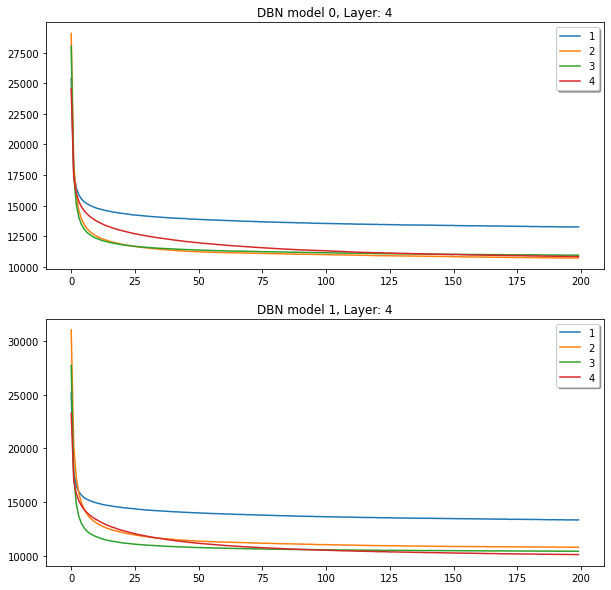

In [ ]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

i=0
n_models = len(dbn_models)
fig, axes = plt.subplots(n_models, figsize=(10,10))

for dbn_model in dbn_models:
  nlayers = dbn_model.DN['nlayers']
  legends = []
  legend_name = []
  if n_models > 1:
      axis = axes[i]
  else:
      axis = axes
  for layer in range(nlayers):
    values = dbn_model.DN['errors'][layer]
    x, y = zip(*values)
    title = 'DBN model {0}, Layer: {1}'.format(i, layer+1)
    
    leg,  = axis.plot(x, y)
    legends.append(leg)
    legend_name.append(str(layer+1))

  axis.legend(legends, legend_name, loc='upper right', shadow=True)
  axis.set_title(title)
  i+=1

plt.show()


(784, 784)


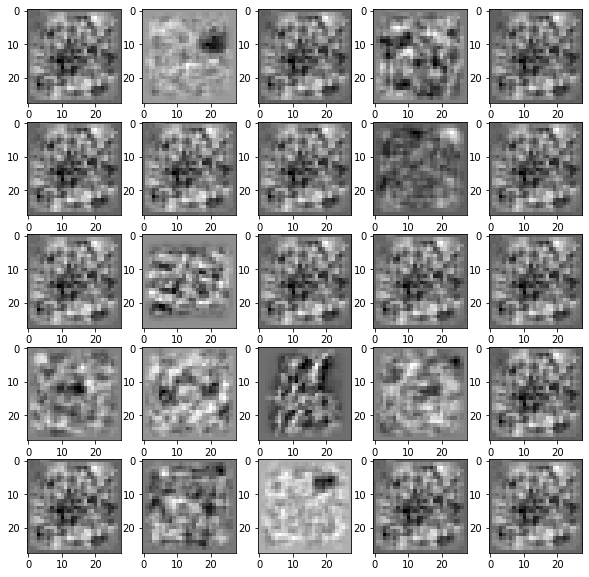

In [ ]:
learned_weights = dbn_model.DN['vishid0'].transpose(1, 0)
print(learned_weights.shape)
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

In [ ]:
import cv2 as cv
def plot_layer(DN, n_hidden):
  #self.DN['vis_bias' layer]
  #self.DN['hid_bias' layer]
  v, h = DN['vishid1'].shape # number of visible and hidden units
  imgsize = math.sqrt(v);
  if n_hidden > h:
      n_hidden = h;

  n_x = math.floor(math.sqrt(n_hidden))
  n_y = n_x
  n_hidden = n_x * n_y;

  plt.show()
  fig = plt.figure(3, figsize=(10,10)) 
  for i_n in range(n_hidden):
    # Select (strong) inputs to L3(i_n)
    W3 = DN['vishid2'][:, i_n]
    #W3 = W3.detach().cpu().clone().numpy()
    W3 = np.multiply(W3, (np.abs(W3) > 0.0))
    # Select (strong) inputs to L2
    W2 = DN['vishid1']
    #W2 = W2.detach().cpu().clone().numpy()
    W2 = np.multiply(W2, (np.abs(W2) > 0.0))
    # Select (strong) inputs to L1
    W1 = DN['vishid0']
    #W1 = W1.detach().cpu().clone().numpy()
    W1 = np.multiply(W1, (np.abs(W1) > 0.0))
    
    # Weight filters with a linear combination
    ww = np.dot(W1, W2)
    ww = np.dot(ww, W3)
    ww = np.multiply(ww, np.abs(ww) > 0.0) # threshold
    print(max(abs(ww)))
    ww=ww/max(abs(ww))

    print(ww.shape)
    #print(ww)
    sub = fig.add_subplot(n_y, n_x, i+1)
    sub.imshow(ww.reshape((imgsize, imgsize)), cmap=plt.cm.gray)
    plt.show()
    #pl = subplot(n_y, n_x, i_n)
    #imagesc(reshape(ww,imgsize,imgsize)); %(1:end-2)
    #colormap('gray'); axis square; axis off


In [ ]:
plot_layer(dbn_model.DN, 100)